# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')
from numpy.linalg import inv
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц можно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

#### Нам нужна только диагональ обратной матрицы
#### На месте бесконечных элементов в обратной появятся нули, а на месте остальных - соответствующие элементы подматрицы, образованной вычёркиванием строк и столбцов с бесконечными элементами

In [3]:
def get_w_sigma(X, t, alpha, beta, alpha_bound=10**6, weigth_bound=10**-12, XTX=None):
    """Calculate the mean and diagonal of the covariance matrix
       of the posterior distribution"""
    if XTX is None:
        XTX = X.T.dot(X)

    finite_numbers_mask = alpha < alpha_bound

    sigma_inverse = beta * XTX[finite_numbers_mask][:, finite_numbers_mask]
    indices = np.arange(sigma_inverse.shape[1])
    sigma_inverse[(indices, indices)] += alpha[finite_numbers_mask]
    sigma = inv(sigma_inverse)

    sigma_diag = np.empty(X.shape[1])
    sigma_diag[finite_numbers_mask] = sigma[(indices, indices)]
    sigma_diag[~finite_numbers_mask] = 0.

    XTT = X.T.dot(t)
    w = np.empty(X.shape[1])
    w[finite_numbers_mask] = beta * sigma.dot(XTT[finite_numbers_mask])
    w[~finite_numbers_mask] = 0.
    return w, sigma_diag


def update_alpha_beta(X, t, alpha, beta, alpha_bound=10**6, weigth_bound=10**-12, XTX=None):
    """Update the hyperparameters to increase evidence"""
    w, sigma_diag = get_w_sigma(X, t, alpha, beta, alpha_bound, weigth_bound, XTX)

    finite_numbers_mask = (alpha < alpha_bound) & (abs(w) > weigth_bound)
    w[~finite_numbers_mask] = 0.

    alpha_new = np.empty(X.shape[1])
    alpha_new[finite_numbers_mask] = 1 - alpha[finite_numbers_mask] * sigma_diag[finite_numbers_mask]
    alpha_new[finite_numbers_mask] /= w[finite_numbers_mask] ** 2
    alpha_new[~finite_numbers_mask] = np.inf

    beta_new = X.shape[0] - (1 - alpha[finite_numbers_mask] * sigma_diag[finite_numbers_mask]).sum()
    beta_new /= ((X.dot(w) - t) ** 2).sum()
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""
    alpha = np.ones(X.shape[1], dtype=float)
    beta = 1.
    XTX = X.T.dot(X)
    for i in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta, XTX=XTX)
    w, sigma_diag = get_w_sigma(X, t, alpha, beta, XTX=XTX)
    return w, sigma_diag, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

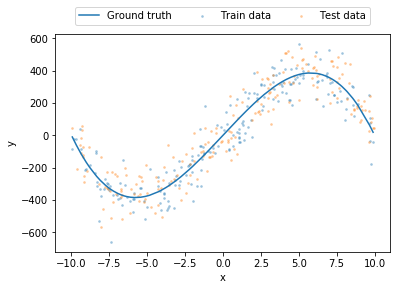

In [4]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-10, 10, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 100
w_true[3] = -1
beta_true = 1e-4

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [5]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, 10000)

In [6]:
w_rvr

array([  0.        , 100.26572402,   0.        ,  -1.01849279,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

In [7]:
alpha_rvr

array([           inf, 9.93831796e-05,            inf, 9.61886323e-01,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf])

In [8]:
beta_rvr

0.00010773558337532083

In [9]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [10]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

Relevance Vector Regression
Features remaining: 2 / 21
Train error: 9189.30784476839
Test error:  9530.95637989324
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 8090.974378410272
Test error:  12254.378385805721
--------------------------------------------------
Lasso Regression
Features remaining: 19 / 21
Train error: 8941.2284797606
Test error:  10237.840502708417


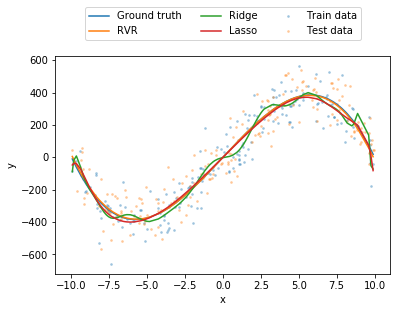

In [11]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
plt.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
plt.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
plt.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

# Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

(500,)


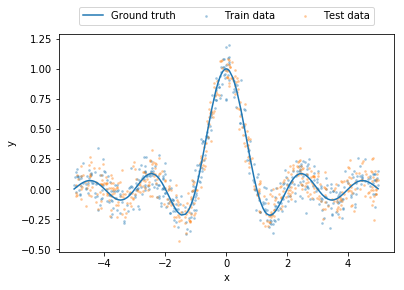

In [12]:
# Генерация данных
def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 500
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n, beta_true)

print(points_train.shape)

# RBF-transform
X_train = rbf_kernel(points_train[:, np.newaxis], points_train[:, np.newaxis])
X_test = rbf_kernel(points_test[:, np.newaxis], points_train[:, np.newaxis])

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n, 1)), X_test))

# Visualization
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [13]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, max_iter=30000)

In [14]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

In [15]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 11 / 500
Train error: 0.009445466652462996
Test error:  0.00930529009762734
--------------------------------------------------
Lasso Regression
Objects remaining: 148 / 500
Train error: 0.009456249975432643
Test error:  0.009346618825209532
--------------------------------------------------
Support Vector Regression
Objects remaining: 163 / 500
Train error: 0.00947339587180842
Test error:  0.009481802574935881


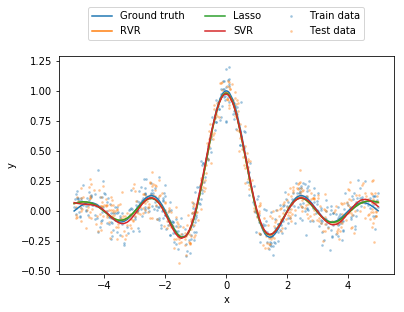

In [16]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')
plt.plot(points_train, X_train.dot(w_lasso), label='Lasso')
plt.plot(points_train, svr.predict(points_train.reshape(-1, 1)), label='SVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

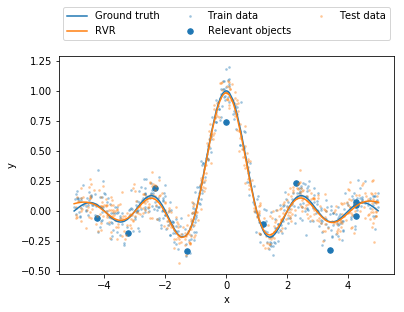

In [17]:
relevant = alpha_rvr[1:] < 1e8
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы
Байесовская линейная регрессия - обобщение обычной, если ещё правильно подобрать ограничения на веса w и обратные дисперсии весов $\alpha$, то можно получить результат чуть лучше, чем у Lasso и Ridge регрессий. Можно делать переход к радиальным базисным функциям